In [38]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
from tqdm import tqdm
import random
from skimage.draw import bezier_curve
from scipy.ndimage import gaussian_filter
import json
from torch.utils.data import Dataset, DataLoader
import torch
import time

In [2]:
random.seed(42)
np.random.seed(42)
data_dir = './reduced_dset'

In [20]:
# === Paths ===
ann_file = os.path.join(data_dir, 'annotations', 'instances_train2014.json')
img_dir = os.path.join(data_dir, 'train2014')

# === Load COCO ===
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# === Dataset preprocessing ===
input_dir = os.path.join(data_dir, 'masks')
output_dir = os.path.join(data_dir, 'coarse_masks')

os.makedirs(output_dir, exist_ok=True)

mask_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

def random_coarse(mask):
    # Convert to uint8 and ensure contiguous
    mask = np.ascontiguousarray((mask * 255).astype(np.uint8))

    # Step 1: Generate a band around the edge
    contour_band = cv2.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    contour_band = cv2.subtract(contour_band, mask)

    # Get coordinates where noise can be placed (in edge band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, dtype=np.uint8)

    # Add random circles only around the contour area
    num_circles = random.randint(15, 40)
    for _ in range(num_circles):
        if len(edge_coords) == 0:
            break
        y, x = edge_coords[random.randint(0, len(edge_coords) - 1)]
        radius = random.randint(3, 10)
        cv2.circle(noise, (x, y), radius, 255, -1)

    # Combine noise with original mask
    mask = cv2.bitwise_or(mask, noise)

    # Step 2: Random dilation
    dilate_kernel_size = random.randint(7, 15)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask = cv2.dilate(mask, kernel_dilate, iterations=random.randint(1, 2))

    # Step 3: Random erosion
    erode_kernel_size = random.randint(5, dilate_kernel_size - 1)
    kernel_erode = cv2.getStructuringElement(random.choice([
        cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
    ]), (erode_kernel_size, erode_kernel_size))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    # Step 4: Gaussian blur + threshold for soft borders
    blur = cv2.GaussianBlur(mask, (5, 5), sigmaX=random.uniform(2.0, 4.5))
    _, coarse_mask = cv2.threshold(blur, random.randint(60, 120), 1, cv2.THRESH_BINARY)

    return coarse_mask.astype(np.uint8)


def random_coarse_v2(mask):
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width   = random.randint(15, 40)                      
    contour_band = cv2.dilate(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(contour_band, mask)
    edge_coords  = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                        
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width//2, band_width)     
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_or(mask, noise)

    close_size = random.randint(band_width//2, band_width)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (close_size, close_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0)) 
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_distanza(mask, sigma_noise=12, blur_sigma=6.0, bias=12):

    mask = (mask > 0).astype(np.uint8)

    d_in  = cv2.distanceTransform(mask,  cv2.DIST_L2, 3)
    d_out = cv2.distanceTransform(1-mask, cv2.DIST_L2, 3)
    signed = d_in - d_out                 

    noise = np.random.randn(*mask.shape).astype(np.float32)
    noise = cv2.GaussianBlur(noise, (0,0), blur_sigma)

    d_hat = signed + sigma_noise * noise - bias
    coarse = (d_hat > 0).astype(np.uint8)

    return coarse



print(f"Generating coarse masks for {len(mask_files)} masks...")

for fname in tqdm(mask_files):
    mask_path = os.path.join(input_dir, fname)
    mask = np.load(mask_path)  # shape: (H, W)

    coarse_mask = random_coarse_v2(mask)
    
    # Save new mask
    coarse_name = fname.replace('splitmask', 'coarsemask')
    output_path = os.path.join(output_dir, coarse_name)
    np.save(output_path, coarse_mask)

Generating coarse masks for 178 masks...


100%|██████████| 178/178 [00:04<00:00, 41.03it/s]


In [22]:
# === Visualize original and coarse masks ===
class CoarseMaskDataset(Dataset):
    def __init__(self, mask_dir, transform_type="v2"):
        self.mask_paths = [os.path.join(mask_dir, f)
                           for f in os.listdir(mask_dir) if f.endswith('.npy')]
        self.transform_type = transform_type

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        mask = np.load(self.mask_paths[idx])  # shape: (H, W)

        if self.transform_type == "v1":
            coarse = random_coarse(mask)
        elif self.transform_type == "v2":
            coarse = random_coarse_v2(mask)
        elif self.transform_type == "dist":
            coarse = random_coarse_distanza(mask)
        else:
            raise ValueError("Unknown transform type")

        # Convert to torch tensors with shape (1, H, W)
        mask_tensor = torch.tensor((mask > 0).astype(np.uint8), dtype=torch.float32).unsqueeze(0)
        coarse_tensor = torch.tensor(coarse, dtype=torch.float32).unsqueeze(0)

        return coarse_tensor, mask_tensor


In [ ]:
# === Function to mantain original dimension ===
def collate_fn_variable(batch):
    coarse_list, mask_list = zip(*batch)
    return list(coarse_list), list(mask_list)


In [24]:
dataset = CoarseMaskDataset(mask_dir=input_dir, transform_type="v2")
loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn_variable)

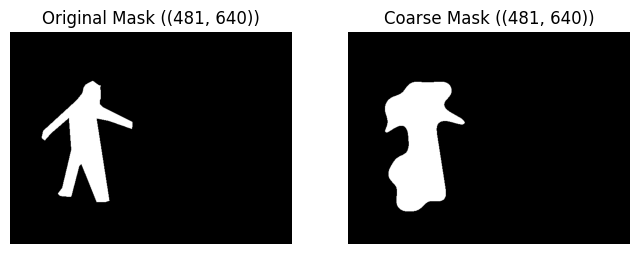

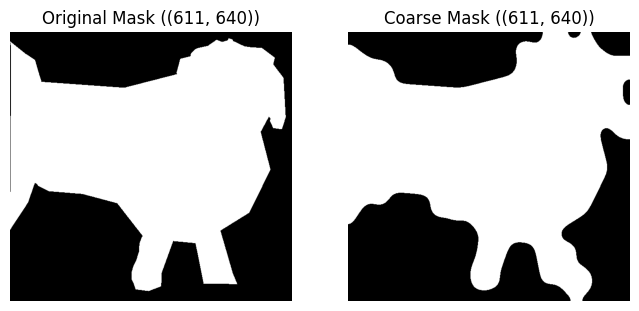

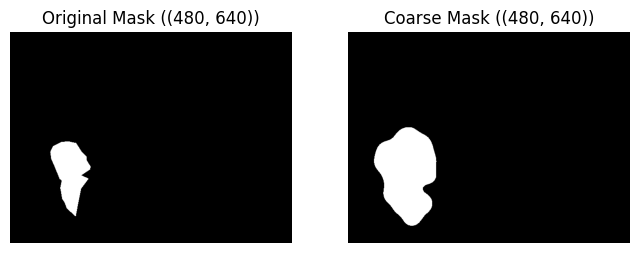

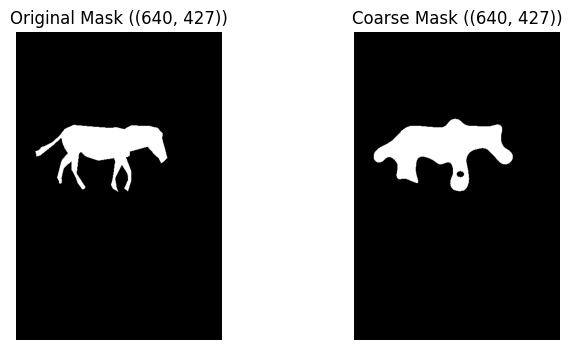

In [25]:

coarse_batch, original_batch = next(iter(loader))

for i in range(len(coarse_batch)):
    coarse = coarse_batch[i][0].numpy()
    original = original_batch[i][0].numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title(f'Original Mask ({original.shape})')
    axs[1].imshow(coarse, cmap='gray')
    axs[1].set_title(f'Coarse Mask ({coarse.shape})')
    for ax in axs: ax.axis('off')
    plt.show()

In [26]:
class CoarseMaskDatasetRGB(Dataset):
    def __init__(self, mask_dir, img_dir, transform_type="v2"):
        self.mask_paths = [os.path.join(mask_dir, f)
                           for f in os.listdir(mask_dir) if f.endswith('.npy')]
        self.img_dir = img_dir
        self.transform_type = transform_type

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        mask_path = self.mask_paths[idx]
        mask_file = os.path.basename(mask_path)
        img_id, _ = mask_file.replace('.npy', '').split('_splitmask')

        # Load original mask and image
        orig_mask = np.load(mask_path)
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Generate coarse mask
        if self.transform_type == "v1":
            coarse_mask = random_coarse(orig_mask)
        elif self.transform_type == "v2":
            coarse_mask = random_coarse_v2(orig_mask)
        elif self.transform_type == "dist":
            coarse_mask = random_coarse_distanza(orig_mask)
        else:
            raise ValueError("Unknown transform type")

        return img, orig_mask, coarse_mask, img_id


In [27]:
def visualize_overlay(img, orig_mask, coarse_mask, img_id, split_i=0):
    overlay = img.copy().astype(np.float32) / 255.0

    # Green for coarse
    overlay[coarse_mask == 1] = overlay[coarse_mask == 1] * 0.5 + np.array([0, 1, 0]) * 0.5

    # Red for original
    overlay[orig_mask == 1] = overlay[orig_mask == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.title(f"Original (RED) vs Coarse (GREEN)\n{img_id}_splitmask{split_i}")
    plt.axis('off')
    plt.show()


In [28]:
datasetrgb = CoarseMaskDatasetRGB(mask_dir=input_dir, img_dir=img_dir, transform_type="v2")
loaderrgb = DataLoader(datasetrgb, batch_size=1, shuffle=True)  # batch_size=1 per immagini variabili


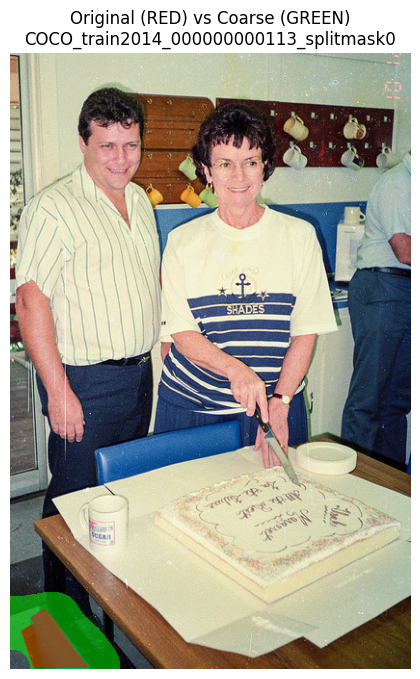

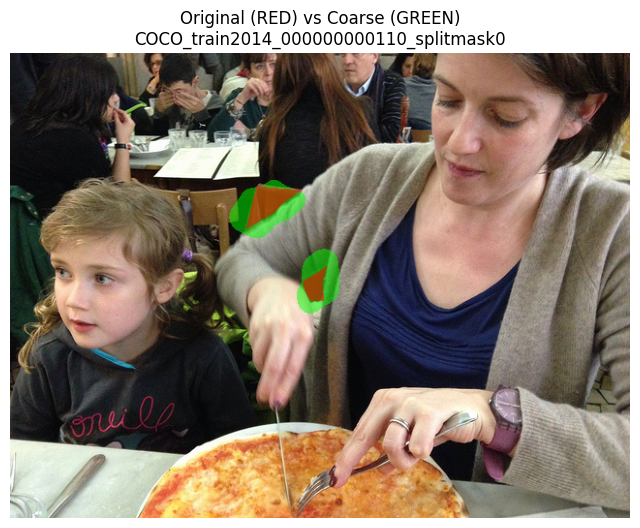

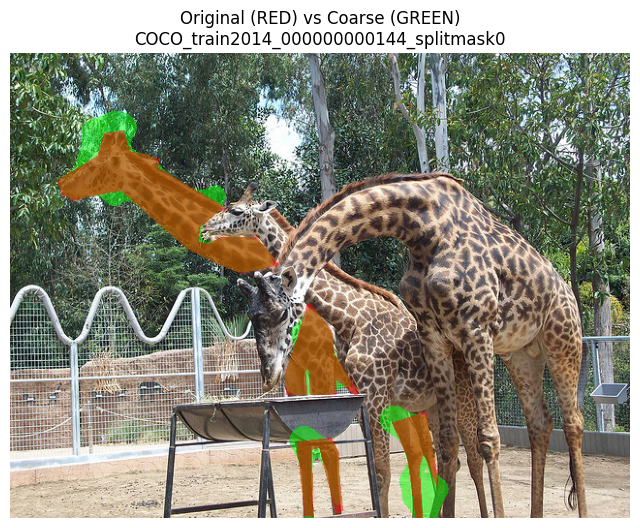

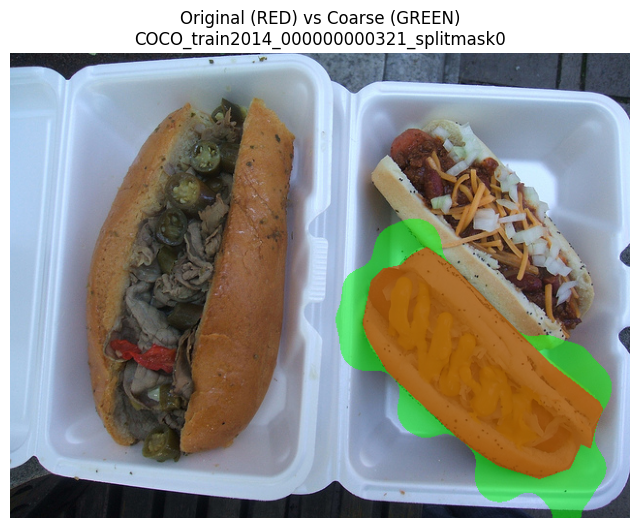

In [29]:

num_images_to_show = 4  # limite
count = 0

for img, orig_mask, coarse_mask, img_id in loaderrgb:
    img = img[0].numpy()
    orig_mask = orig_mask[0].numpy()
    coarse_mask = coarse_mask[0].numpy()
    img_id = img_id[0]

    visualize_overlay(img, orig_mask, coarse_mask, img_id)
    
    count += 1
    if count >= num_images_to_show:
        break

In [30]:
print(len(datasetrgb))

178


In [31]:
print(len(dataset))

178


In [ ]:
start = time.time()
for batch in loaderrgb:
    pass  # Simula training
print("Tempo per scorrere tutto il dataset:", time.time() - start, "secondi")

Tempo per scorrere tutto il dataset: 3.272010564804077 secondi
